# Example: Random KS model (we just take any with Picard Rank 2)

In [1]:
# some general packages
import numpy as np
import os
import pickle

# ML packages
import tensorflow as tf

# data generation
from cymetric.pointgen.pointgen_mathematica import ToricPointGeneratorMathematica
from cymetric.pointgen.nphelper import prepare_dataset, prepare_basis_pickle
from cymetric.models.tfhelper import prepare_tf_basis, train_model

# training
from cymetric.models.tfmodels import PhiFSModelToric
from cymetric.models.callbacks import SigmaCallback, TransitionCallback, RicciCallback, VolkCallback
from cymetric.models.metrics import SigmaLoss, TransitionLoss, RicciLoss, VolkLoss
from cymetric.models.measures import sigma_measure, transition_measure_loss, ricci_measure

## Compute toric information

In [2]:
from cymetric.sage.sagelib import prepare_toric_cy_data

work_dir = "./ToricModel"
vertices = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [-1, -1, -1, 0], [2, 0, 0, -1]]  # P2 fibered over P2
polytope = LatticePolytope(vertices)
pConfig = PointConfiguration(polytope.points(), star=[0 for _ in range(len(vertices[0]))])
triangs = pConfig.restrict_to_connected_triangulations().restrict_to_fine_triangulations().restrict_to_regular_triangulations().restrict_to_star_triangulations([0 for _ in range(len(vertices[0]))]).triangulations_list()
triang = triangs[0]
tv_fan = triang.fan()
tv = ToricVariety(tv_fan)

toric_data = prepare_toric_cy_data(tv, os.path.join(work_dir, "toric_data.pickle"))
list(toric_data.keys())

['dim_cy',
 'vol_j_norm',
 'coeff_aK',
 'exp_aK',
 'exps_sections',
 'patch_masks',
 'glsm_charges',
 'non_ci_coeffs',
 'non_ci_exps',
 'int_nums']

## Generate points

In [3]:
work_dir = "./ToricModel"
with open(os.path.join(work_dir, 'toric_data.pickle'), 'rb') as f:
    toric_data = pickle.load(f)
num_pts       = int(50000)
precision     = int(10)
verbose       = int(1)
kmoduli       = np.ones(len(toric_data['exps_sections']))

In [4]:
mathematica_pointgen = ToricPointGeneratorMathematica(toric_data, kmoduli, precision=precision, verbose=verbose)

In [5]:
kappa = mathematica_pointgen.prepare_dataset(num_pts, work_dir)
prepare_basis_pickle(mathematica_pointgen, work_dir, kappa);

WolframKernel-<tcp://127.0.0.1:49820>:INFO:Connected to logging socket: tcp://127.0.0.1:49820
WolframKernel-<tcp://127.0.0.1:49820>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 6 Mathematica kernels.
pointgenMathematica:DEBUG:Initializing generation of 50000 points...
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Number of points on CY from one ambient space intersection: 4
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Now generating 50000 points...
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 0% of points
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 5% of points
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 10% of points
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 15% of points
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 20% of points
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 25% of points
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 30% of points
WolframKernel-<tcp://127.0.0.1:49820>:INFO:Generated 35%

## set up NN

load in data

In [6]:
tf.get_logger().setLevel('ERROR')
data = np.load(os.path.join(work_dir, 'dataset.npz'))
toric_data = np.load(os.path.join(work_dir, 'toric_data.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(np.load(os.path.join(work_dir, 'basis.pickle'), allow_pickle=True))

set up NN callbacks (info on training process)

In [7]:
scb = SigmaCallback((data['X_val'], data['y_val']))
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
volkck = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, volkck, rcb]

cmetrics = [SigmaLoss(), VolkLoss()]

define the NN hyperparameters (wrapping everything in int() and float() is necessary in sage)

In [8]:
nfold       = int(BASIS['NFOLD'].numpy().real)
amb         = [int(6)]
n_in        = int(12)
n_out       = int(1)
n_hiddens   = [int(64), int(64), int(64)]
acts        = ['gelu', 'gelu', 'gelu']
n_epochs    = int(30)
batch_sizes = [int(64), int(40000)]
alpha       = [float(1.), float(1.), float(1.), float(1.), float(1.)]

initialize the NN and the Toric Phi Model

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(int(n_in))))
for n_hidden, act in zip(n_hiddens, acts):
    model.add(tf.keras.layers.Dense(n_hidden, activation=act))
model.add(tf.keras.layers.Dense(n_out, use_bias=False))

fs_model = PhiFSModelToric(model, BASIS, alpha=alpha, toric_data=toric_data)

## train NN

In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # mostly silences TF logger
fs_model, training_history = train_model(fs_model, data, epochs=n_epochs, batch_sizes=batch_sizes,
                                         verbose=1, custom_metrics=cmetrics, callbacks=cb_list)

Epoch  1/30


2022-04-04 15:54:30.353587: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 - Sigma measure val:      0.4870
 - Volk val:               23.2764
 - Ricci measure val:      8.3826
701/704 [============================>.] - ETA: 0s - sigma_loss: 0.3601 - volk_loss: 0.0000e+00 - Sigma measure val:      0.3812
 - Volk val:               14.7579
 - Ricci measure val:      6.9053
704/704 [==============================] - 24s 27ms/step - sigma_loss: 0.3599 - volk_loss: 0.0000e+00 - sigma_val: 0.3812 - volk_val: 14.7579 - ricci_val: 6.9053
 - Sigma measure val:      0.3812
 - Volk val:               14.7579
 - Ricci measure val:      6.9053


/Users/ruehle/venv-ml/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:2", shape=(None,), dtype=int64), values=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:1", shape=(None, 90, 6), dtype=complex64), dense_shape=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:3", shape=(3,), dtype=int64))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/ruehle/venv-ml/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:5", shape=(None,), dtype=int64), values=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/Partitio

2/2 [==============================] - ETA: 0s - sigma_loss: 0.3069 - volk_loss: 6.1643 - Sigma measure val:      0.3807
 - Volk val:               13.8104
 - Ricci measure val:      6.8226
2/2 [==============================] - 16s 6s/step - sigma_loss: 0.3069 - volk_loss: 6.1643 - sigma_val: 0.3807 - volk_val: 13.8104 - ricci_val: 6.8226
Epoch  2/30
 - Sigma measure val:      0.3807
 - Volk val:               13.8104
 - Ricci measure val:      6.8226
701/704 [============================>.] - ETA: 0s - sigma_loss: 0.2999 - volk_loss: 0.0000e+00 - Sigma measure val:      0.3613
 - Volk val:               14.7085
 - Ricci measure val:      6.8002
704/704 [==============================] - 18s 22ms/step - sigma_loss: 0.2997 - volk_loss: 0.0000e+00 - sigma_val: 0.3613 - volk_val: 14.7085 - ricci_val: 6.8002
 - Sigma measure val:      0.3613
 - Volk val:               14.7085
 - Ricci measure val:      6.8002
2/2 [==============================] - ETA: 0s - sigma_loss: 0.2822 - volk_loss:

 - Sigma measure val:      0.2570
 - Volk val:               17.1633
 - Ricci measure val:      6.7820
2/2 [==============================] - ETA: 0s - sigma_loss: 0.1935 - volk_loss: 7.8796 - Sigma measure val:      0.2563
 - Volk val:               16.5987
 - Ricci measure val:      6.6247
2/2 [==============================] - 18s 10s/step - sigma_loss: 0.1935 - volk_loss: 7.8796 - sigma_val: 0.2563 - volk_val: 16.5987 - ricci_val: 6.6247
Epoch 11/30
 - Sigma measure val:      0.2563
 - Volk val:               16.5987
 - Ricci measure val:      6.6247
700/704 [============================>.] - ETA: 0s - sigma_loss: 0.1945 - volk_loss: 0.0000e+00 - Sigma measure val:      0.2525
 - Volk val:               16.7392
 - Ricci measure val:      6.6577
704/704 [==============================] - 16s 20ms/step - sigma_loss: 0.1944 - volk_loss: 0.0000e+00 - sigma_val: 0.2525 - volk_val: 16.7392 - ricci_val: 6.6577
 - Sigma measure val:      0.2525
 - Volk val:               16.7392
 - Ricci m

 - Sigma measure val:      0.2273
 - Volk val:               17.9333
 - Ricci measure val:      7.5665
2/2 [==============================] - ETA: 0s - sigma_loss: 0.1635 - volk_loss: 8.3521 - Sigma measure val:      0.2283
 - Volk val:               17.5509
 - Ricci measure val:      7.9152
2/2 [==============================] - 15s 7s/step - sigma_loss: 0.1635 - volk_loss: 8.3521 - sigma_val: 0.2283 - volk_val: 17.5509 - ricci_val: 7.9152
Epoch 20/30
 - Sigma measure val:      0.2283
 - Volk val:               17.5509
 - Ricci measure val:      7.9152
702/704 [============================>.] - ETA: 0s - sigma_loss: 0.1634 - volk_loss: 0.0000e+00 - Sigma measure val:      0.2173
 - Volk val:               17.7509
 - Ricci measure val:      6.5460
704/704 [==============================] - 18s 22ms/step - sigma_loss: 0.1634 - volk_loss: 0.0000e+00 - sigma_val: 0.2173 - volk_val: 17.7509 - ricci_val: 6.5460
 - Sigma measure val:      0.2173
 - Volk val:               17.7509
 - Ricci me

 - Sigma measure val:      0.2045
 - Volk val:               17.6952
 - Ricci measure val:      7.6673
2/2 [==============================] - ETA: 0s - sigma_loss: 0.1455 - volk_loss: 8.2066 - Sigma measure val:      0.2048
 - Volk val:               17.3752
 - Ricci measure val:      9.1324
2/2 [==============================] - 14s 6s/step - sigma_loss: 0.1455 - volk_loss: 8.2066 - sigma_val: 0.2048 - volk_val: 17.3752 - ricci_val: 9.1324
Epoch 29/30
 - Sigma measure val:      0.2048
 - Volk val:               17.3752
 - Ricci measure val:      9.1324
703/704 [============================>.] - ETA: 0s - sigma_loss: 0.1475 - volk_loss: 0.0000e+00 - Sigma measure val:      0.2059
 - Volk val:               17.7333
 - Ricci measure val:      15.1202
704/704 [==============================] - 15s 19ms/step - sigma_loss: 0.1476 - volk_loss: 0.0000e+00 - sigma_val: 0.2059 - volk_val: 17.7333 - ricci_val: 15.1202
 - Sigma measure val:      0.2059
 - Volk val:               17.7333
 - Ricci 

Check the volume normailzation of our data

In [11]:
dets_fs = np.real(tf.linalg.det(fs_model.fubini_study_pb(tf.cast(data['X_train'], tf.float32))).numpy())
dets_cy = np.real(tf.linalg.det(fs_model(tf.cast(data['X_train'], tf.float32))).numpy())
weights, omegas = data['y_train'][:,-2], data['y_train'][:,-1]
vol_k_fs = np.mean(weights * dets_fs / omegas)
vol_k_cy = np.mean(weights * dets_cy / omegas)
print("Vol_K from triple intersection numbers at t1=t2=1:                ", toric_data['vol_j_norm'])
print("Vol_K from MC integration over FS metric in Kahler class t1=t2=1: ", np.round(vol_k_fs, 2))
print("Vol_K from MC integration over CY metric in Kahler class t1=t2=1: ", np.round(vol_k_cy, 2))

Vol_K from triple intersection numbers at t1=t2=1:                 20
Vol_K from MC integration over FS metric in Kahler class t1=t2=1:  19.99
Vol_K from MC integration over CY metric in Kahler class t1=t2=1:  17.76


... and look at the value of the Kahler potential

In [12]:
fs_model.get_kahler_potential(data['X_train'][:10])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.33434856, 0.37565917, 0.32292545, 0.26137507, 0.50044584,
       0.44852358, 0.2489092 , 0.22698036, 0.28524846, 0.22972664],
      dtype=float32)>

## Plot the results

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

Note that vol_k val should be constant (and equal to 20.0). So in this case, it is off by 15%)

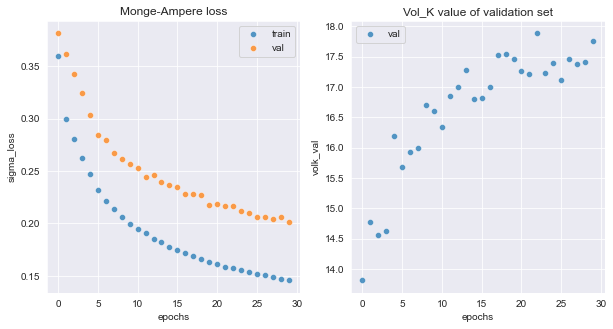

In [27]:
hist = training_history
hist['epochs'] = list(range(n_epochs))
hist_data = pd.DataFrame(hist)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5));
ax1.set_title("Monge-Ampere loss")
sns.scatterplot(x='epochs', y='sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="train")
sns.scatterplot(x='epochs', y='sigma_val', data=hist_data, alpha=0.75, ax=ax1, label="val")

ax2.set_title("Vol_K value of validation set")
sns.scatterplot(x='epochs', y='volk_val', data=hist_data, alpha=0.75, ax=ax2, label="val");